In [200]:
import requests
from xml.etree import ElementTree as ET

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import anderson
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
import os   

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## DATASET

In [201]:
raw_fog = pd.read_csv(f'C:/Users/LG/PythonDataWorkspace/DATA STUDY/fog_data/fog_train.csv', encoding = 'euc-kr')
fog_test = pd.read_csv(f'C:/Users/LG/PythonDataWorkspace/DATA STUDY/fog_data/fog_test.csv', encoding = 'euc-kr')

raw_fog

,Unnamed: 0,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
0,1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
3,4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
4,5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156455,3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156456,3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156457,3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [202]:
def raw_data_preprocessing_train(dataset):

    fog_data = dataset.copy()

    fog_data = fog_data.drop(['Unnamed: 0'], axis = 1)

    fog_data = fog_data.replace(-99.00, np.NaN)
    fog_data = fog_data.replace(-99.90, np.NaN)

    columns = fog_data.columns
    columns = [column.replace('fog_train.', "") for column in columns]
    fog_data.columns = columns

    return fog_data

def raw_data_preprocessing_test(dataset):

    fog_data = dataset.copy()

    fog_data = fog_data.replace(-99.00, np.NaN)
    fog_data = fog_data.replace(-99.90, np.NaN)

    fog_data = fog_data.drop(['Unnamed: 0'], axis = 1)

    columns = fog_data.columns
    columns = [column.replace('fog_test.', "") for column in columns]
    fog_data.columns = columns
    fog_data = fog_data.drop(['class'], axis = 1)

    return fog_data

In [203]:
fog_data = raw_data_preprocessing_train(raw_fog)

fog_data = fog_data.drop(['year', 'month', 'day', 'time', 'minute'], axis = 1)

fog_test = raw_data_preprocessing_test(fog_test)

fog_test = fog_test.drop(['year', 'month', 'day', 'time', 'minute'], axis = 1)

fog_data

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0
1,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0
2,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0
3,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0
4,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0
...,...,...,...,...,...,...,...,...,...,...
3156454,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0
3156455,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0
3156456,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0
3156457,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0


In [204]:
def labelencoding_for_territory(dataset):

    stn_list = dataset['stn_id'].str[0]

    dataset['stn_id'] = stn_list

    stn_encoding_df = pd.DataFrame({
        'stn_id' : ['A', 'B', 'C', 'D', 'E'],
        'stn_num' : [1, 2, 3, 4, 5]
    })

    stn_encoding_map = stn_encoding_df.set_index('stn_id')['stn_num'].to_dict()
    # df를 series로 만든 후 dict형태로 변환하기
    dataset['stn_id'] = dataset['stn_id'].map(stn_encoding_map)
    return dataset

In [205]:
fog_data = labelencoding_for_territory(fog_data)
fog_test = labelencoding_for_territory(fog_test)

In [206]:
fog_data

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0
1,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0
2,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0
3,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0
4,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0
...,...,...,...,...,...,...,...,...,...,...
3156454,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0
3156455,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0
3156456,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0
3156457,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0


## EDA

### basis

In [207]:
data_eda = fog_data.copy()
round(data_eda.describe(), 2)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
count,3156459.00,3150549.00,3150633.00,3152592.00,3141231.00,3152843.00,3112549.00,3067820.00,3133943.00,3133943.00
mean,2.45,185.75,2.19,13.43,0.05,66.87,0.10,16.09,19777.27,3.98
std,1.50,106.60,1.76,10.27,0.22,21.00,0.16,12.10,11990.38,0.20
min,1.00,0.00,0.00,-24.30,0.00,0.00,0.00,-4.90,1.00,1.00
25%,1.00,85.40,0.90,5.50,0.00,51.30,0.00,6.00,12500.00,4.00
50%,2.00,209.80,1.80,14.30,0.00,68.70,0.00,16.30,20000.00,4.00
75%,4.00,277.00,3.00,22.00,0.00,84.70,0.17,24.50,20000.00,4.00
max,5.00,360.00,22.50,37.80,1.00,100.00,26.87,70.10,60525.00,4.00


In [208]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156459 entries, 0 to 3156458
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   stn_id    int64  
 1   ws10_deg  float64
 2   ws10_ms   float64
 3   ta        float64
 4   re        float64
 5   hm        float64
 6   sun10     float64
 7   ts        float64
 8   vis1      float64
 9   class     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 MB


#### 결측치 확인

In [209]:
def null_check(df):
    
    print('[ 결측치 확인 ]')
    print("(전체 row 수 : ", len(df), ")")
    print('')
    print('-' * 35)

    for column in df.columns:
        
        if df[column].isna().sum() == 0:
            pass

        else:
            print()
            print(column + " 결측치 비율:", round(df[column].isna().sum() / len(df) * 100, 2), "%")
            print('-' * 35)

    msno.matrix(df = df, figsize = (5, 5), color = (0.8, 0.5, 0.2), fontsize = 7);

[ 결측치 확인 ]
(전체 row 수 :  3156459 )

-----------------------------------

ws10_deg 결측치 비율: 0.19 %
-----------------------------------

ws10_ms 결측치 비율: 0.18 %
-----------------------------------

ta 결측치 비율: 0.12 %
-----------------------------------

re 결측치 비율: 0.48 %
-----------------------------------

hm 결측치 비율: 0.11 %
-----------------------------------

sun10 결측치 비율: 1.39 %
-----------------------------------

ts 결측치 비율: 2.81 %
-----------------------------------

vis1 결측치 비율: 0.71 %
-----------------------------------

class 결측치 비율: 0.71 %
-----------------------------------


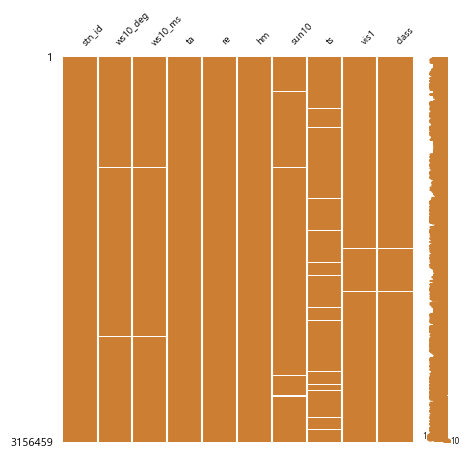

In [210]:
null_check(fog_data)

In [211]:
data_eda = data_eda.dropna()

#### 컬럼별 분포 확인

In [212]:
def dist(df):

    dist_column_list = []

    for column in df.columns:
        if (df.dtypes[column] == 'int64') | (df.dtypes[column] == 'float'):
            dist_column_list.append(column)
        else:
            pass

    n_plot = len(dist_column_list)
    fig, axes = plt.subplots(n_plot, 1, figsize = (7, 20))
    for i, dist_column in enumerate(dist_column_list):
        axes[i].hist(df[dist_column].values, bins = 100, color = 'gray', edgecolor = 'gray')
        axes[i].set_title("[ " + dist_column + " ]" + " distribution")

    plt.tight_layout(h_pad = 3)
    plt.show()

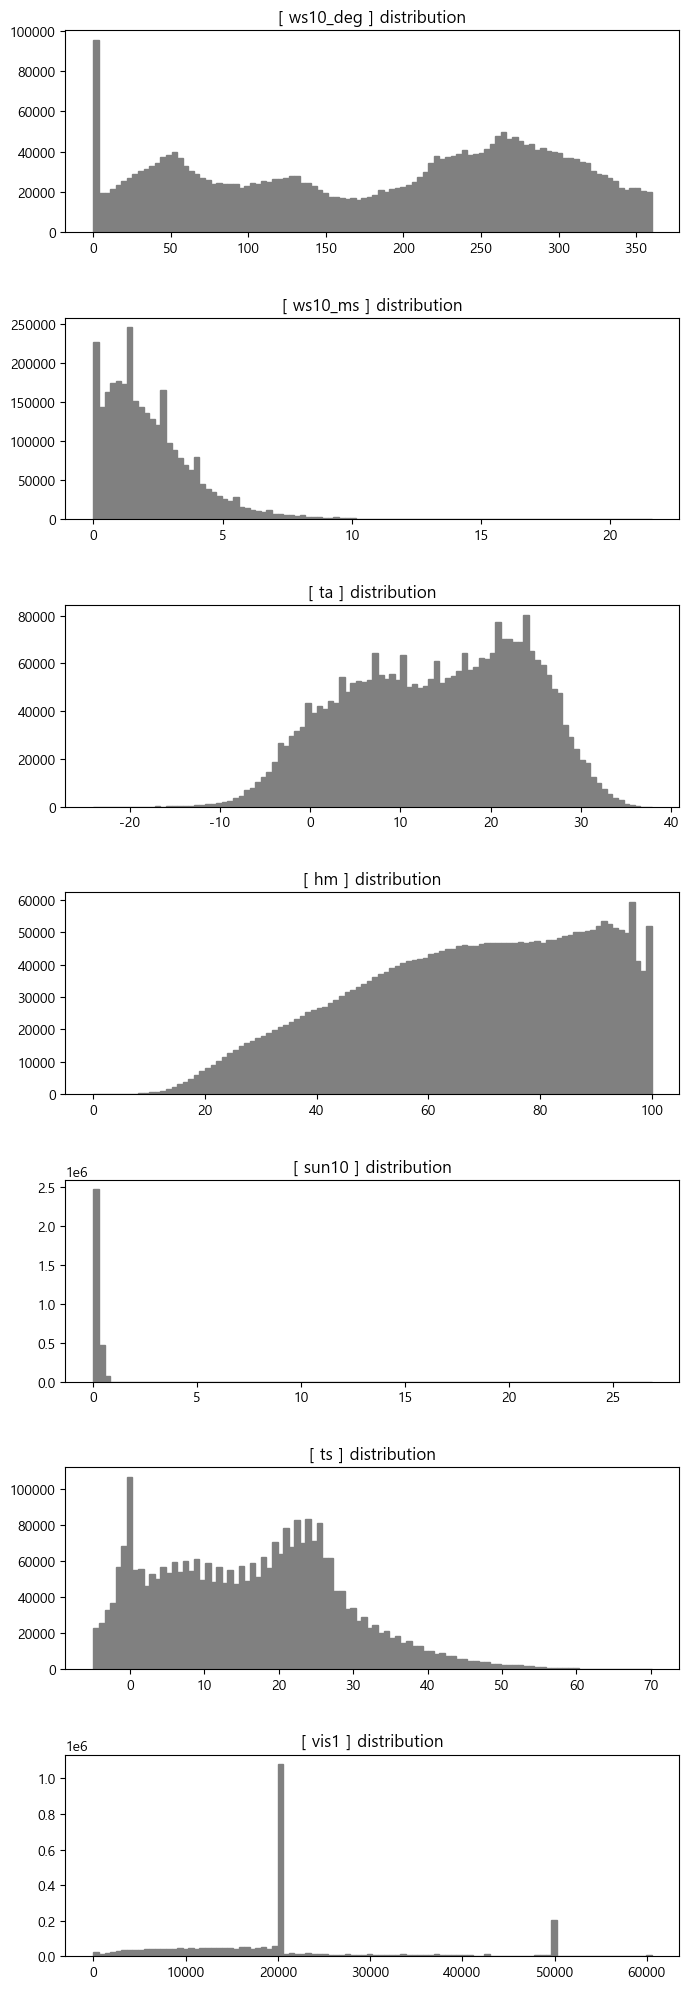

In [213]:
dist(data_eda.drop(['stn_id', 're', 'class'], axis = 1))

#### 이슬점을 고려한 column

In [214]:
def calculate_dew_point(T, RH):
    a = 17.27
    b = 237.7
    gamma = (a * T) / (b + T) + np.log(RH / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    return dew_point

In [215]:
data_eda['dew_point'] = calculate_dew_point(data_eda['ta'], data_eda['hm'])

c:\ProgramData\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [216]:
dew_re_list = []
for i in range(len(data_eda)):
    if data_eda['ts'].values[i] < data_eda['dew_point'].values[i]:
        dew_re_list.append(1)
    else:
        dew_re_list.append(0)
data_eda['dew_reached'] = dew_re_list
data_eda

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,dew_point,dew_reached
0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0,-18.083476,0
1,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0,-18.299136,0
2,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0,-17.664937,0
3,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0,-17.722897,0
4,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0,-17.543307,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,-6.810493,0
3156455,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,-7.021146,0
3156456,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,-6.882689,0
3156457,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,-6.798347,0


#### 클래스별 비율

In [217]:
data_eda['diff'] = data_eda['ta'] - data_eda['ts']
data_eda = data_eda[['stn_id', 'ws10_deg', 'ws10_ms', 're', 'hm', 'sun10', 'ta', 'ts', 'diff', 'dew_point', 'dew_reached', 'vis1', 'class']]
data_eda

,stn_id,ws10_deg,ws10_ms,re,hm,sun10,ta,ts,diff,dew_point,dew_reached,vis1,class
0,1,0.0,0.0,0.0,38.9,0.0,-6.4,-2.8,-3.6,-18.083476,0,20000.0,4.0
1,1,0.0,0.0,0.0,37.9,0.0,-6.3,-2.7,-3.6,-18.299136,0,20000.0,4.0
2,1,0.0,0.0,0.0,40.0,0.0,-6.3,-2.6,-3.7,-17.664937,0,20000.0,4.0
3,1,27.8,0.4,0.0,39.5,0.0,-6.2,-2.6,-3.6,-17.722897,0,20000.0,4.0
4,1,59.7,0.5,0.0,39.8,0.0,-6.1,-2.5,-3.6,-17.543307,0,20000.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,5,305.3,7.7,0.0,50.2,0.0,2.5,-0.9,3.4,-6.810493,0,20000.0,4.0
3156455,5,293.8,5.7,0.0,50.1,0.0,2.3,-1.3,3.6,-7.021146,0,20000.0,4.0
3156456,5,274.2,4.9,0.0,51.0,0.0,2.2,-1.4,3.6,-6.882689,0,20000.0,4.0
3156457,5,270.3,4.6,0.0,51.7,0.0,2.1,-1.6,3.7,-6.798347,0,20000.0,4.0


In [218]:
def class_info(dataset, msg = ""):
    try:

        unique_values, counts = np.unique(dataset['class'], return_counts = True)
        
        print("[ " + msg + "의 class별 count / ratio ]")
        print("-"*40)
        for value, count in zip(unique_values, counts):
            print('class ' + f'{int(value)}: {count}' + " / " + str(round(count/len(dataset['class'])*100, 2)) + "%")
        
        print("-"*40)
        fog_count = len(dataset[dataset['class'] < 4]['class'])
        print("안개 : " + str(fog_count) + " / " + str(round(fog_count/len(dataset['class'])*100, 2)) + "%")

    except:

        unique_values, counts = np.unique(dataset, return_counts = True)
        
        print("[ " + msg + "의 class별 count / ratio ]")
        print("-"*40)
        for value, count in zip(unique_values, counts):
            print('class ' + f'{int(value)}: {count}' + " / " + str(round(count/len(dataset)*100, 2)) + "%")
        
        print("-"*40)
        fog_count = len(dataset[dataset < 4])
        print("안개 : " + str(fog_count) + " / " + str(round(fog_count/len(dataset)*100, 2)) + "%")
        

In [219]:
class_info(data_eda, "전체 trainset")

[ 전체 trainset의 class별 count / ratio ]
----------------------------------------
class 1: 7806 / 0.26%
class 2: 11975 / 0.4%
class 3: 11940 / 0.4%
class 4: 2963129 / 98.94%
----------------------------------------
안개 : 31721 / 1.06%


#### 다중공선성

In [220]:
cont_eda = data_eda.drop(['stn_id', 're', 'vis1', 'class', 'diff', 'dew_reached'], axis = 1)

vif = pd.DataFrame()
vif["features"] = cont_eda.columns
vif["VIF Factor"] = [variance_inflation_factor(cont_eda.values, i) for i in range(cont_eda.shape[1])]
vif

MissingDataError: exog contains inf or nans

### 연속형 변수

#### 요소별 상관관계

In [221]:
cat_columns = ['stn_id', 're', 'class', 'dew_reached']
data_eda_con = data_eda.drop(cat_columns, axis = 1)
data_eda_cat = data_eda[cat_columns]

In [242]:
data_eda[data_eda['dew_reached'] == 1]

,stn_id,ws10_deg,ws10_ms,re,hm,sun10,ta,ts,diff,dew_point,dew_reached,vis1,class
831,1,69.7,4.7,0.0,92.0,0.0,3.0,1.8,1.2,1.828930,1,3068.0,4.0
833,1,74.3,4.7,1.0,92.3,0.0,3.1,1.9,1.2,1.973506,1,3045.0,4.0
834,1,67.0,4.4,0.0,92.5,0.0,3.1,1.9,1.2,2.003799,1,2762.0,4.0
835,1,69.8,4.7,0.0,92.7,0.0,3.2,2.0,1.2,2.133150,1,3455.0,4.0
836,1,69.0,4.6,0.0,92.8,0.0,3.2,1.9,1.3,2.148258,1,3593.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151744,5,281.1,3.0,0.0,91.6,0.0,18.7,17.0,1.7,17.302560,1,10714.0,4.0
3151745,5,322.2,5.1,0.0,90.1,0.0,18.8,16.8,2.0,17.139994,1,20000.0,4.0
3151746,5,321.4,5.6,0.0,87.8,0.0,18.8,16.6,2.2,16.731559,1,20000.0,4.0
3153319,5,266.7,1.5,0.0,74.8,0.0,6.6,2.4,4.2,2.450360,1,7692.0,4.0


<Axes: >

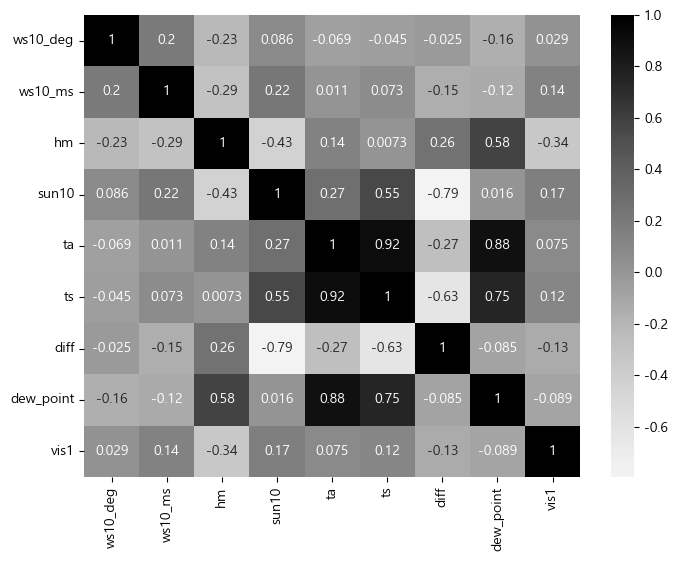

In [222]:
eda_corr = data_eda_con.corr()
plt.figure(figsize = (8, 6))
sns.heatmap(eda_corr, annot = True, cmap = 'Greys', center = 0)

#### 클래스별 요소값들의 평균

In [223]:
def avg_factor_class(dataset, class_column = 'class'):

    about_columns = dataset.columns[0:-2]

    for column in about_columns:
        print("[ " + column + "의 class별 평균 / 표준표차 ]")
        print("-" * 40)

        for i in range(1, 5):
            temp_df = dataset[dataset[class_column] == i]
            print('class ' + str(i) + "의 " + column + "에 대한 평균" + str(round(temp_df[column].mean(), 3)) + " / 표준편차 " + str(round(temp_df[column].std(), 3)))
            
        print("-" * 40)

In [224]:
avg_factor_class(data_eda.drop(['stn_id', 're', 'vis1'], axis = 1))

[ ws10_deg의 class별 평균 / 표준표차 ]
----------------------------------------
class 1의 ws10_deg에 대한 평균152.478 / 표준편차 113.961
class 2의 ws10_deg에 대한 평균162.817 / 표준편차 111.427
class 3의 ws10_deg에 대한 평균170.389 / 표준편차 109.212
class 4의 ws10_deg에 대한 평균185.18 / 표준편차 106.344
----------------------------------------
[ ws10_ms의 class별 평균 / 표준표차 ]
----------------------------------------
class 1의 ws10_ms에 대한 평균1.248 / 표준편차 1.401
class 2의 ws10_ms에 대한 평균1.21 / 표준편차 1.463
class 3의 ws10_ms에 대한 평균1.634 / 표준편차 1.677
class 4의 ws10_ms에 대한 평균2.196 / 표준편차 1.752
----------------------------------------
[ hm의 class별 평균 / 표준표차 ]
----------------------------------------
class 1의 hm에 대한 평균93.945 / 표준편차 9.431
class 2의 hm에 대한 평균93.665 / 표준편차 9.652
class 3의 hm에 대한 평균93.453 / 표준편차 8.367
class 4의 hm에 대한 평균66.789 / 표준편차 20.962
----------------------------------------
[ sun10의 class별 평균 / 표준표차 ]
----------------------------------------
class 1의 sun10에 대한 평균0.014 / 표준편차 0.044
class 2의 sun10에 대한 평균0.021 / 표준편차 0.061
class 3의 sun

#### 클래스별 요소값들의 kdeplot

In [225]:
def kde_factor_class(dataset, class_column = 'class'):

    colors = {
    1: '#FF0000',
    2: '#00FF00',
    3: '#0000FF',
    4: '#777777'
}


    about_columns = dataset.columns[0:-2]

    for column in about_columns:
        plt.figure(figsize = (10, 6))
        for i in range(1, 5):
            temp_df = dataset[dataset[class_column] == i]
            sns.kdeplot(temp_df[column], label = i, fill = True, color = colors[i])
        plt.title("class별 " + column + "의 kdeplot")
        plt.xlabel(column + " value")
        plt.ylabel('density')
        plt.legend()
        plt.show();

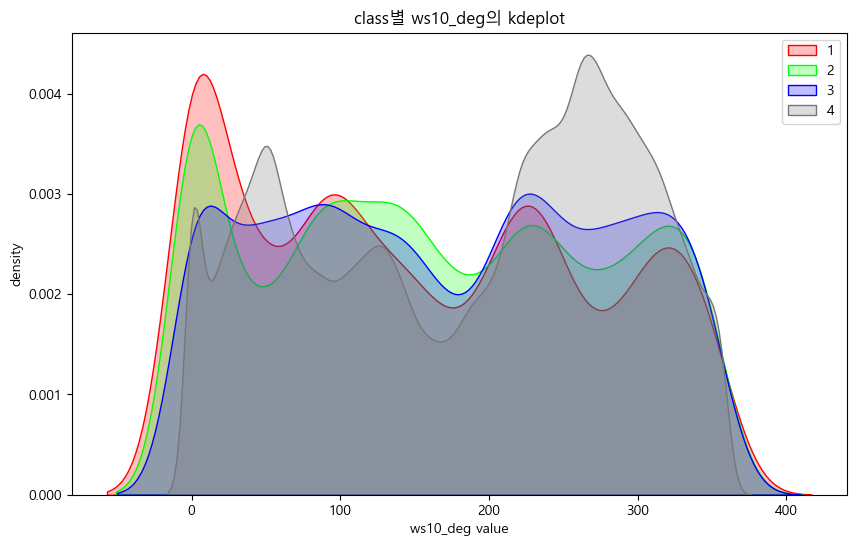

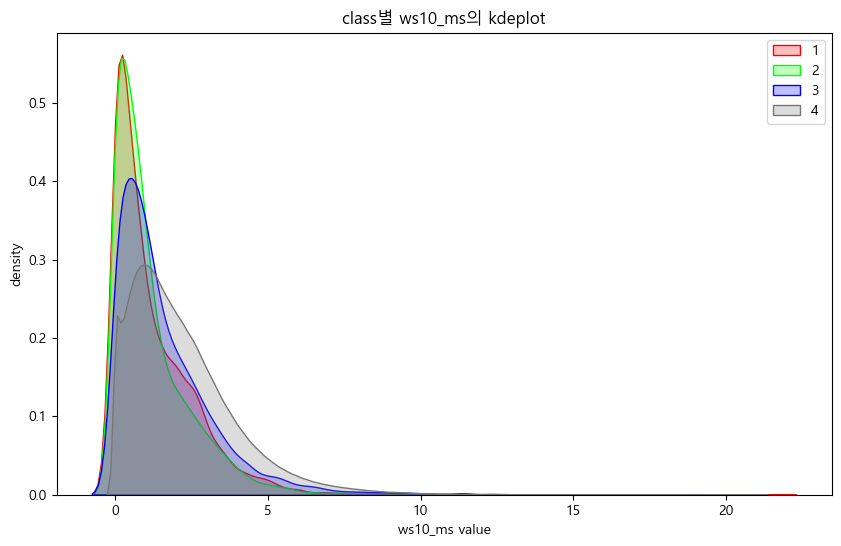

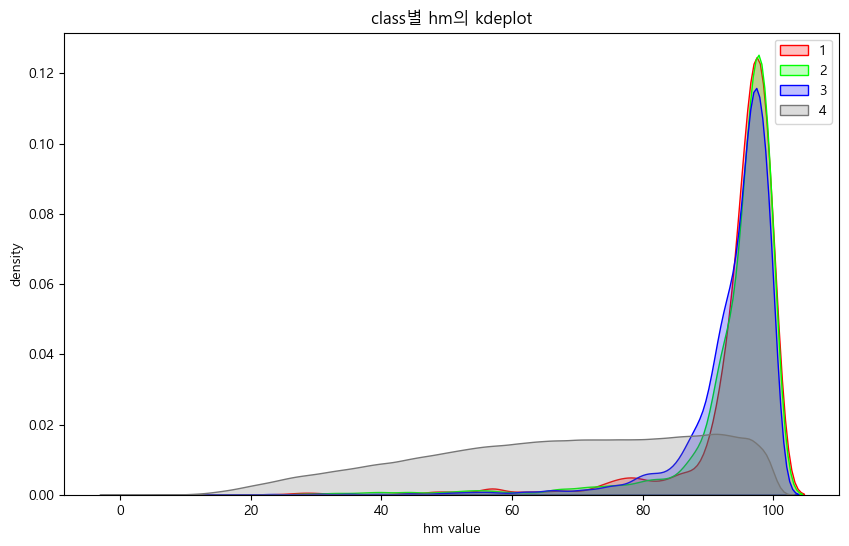

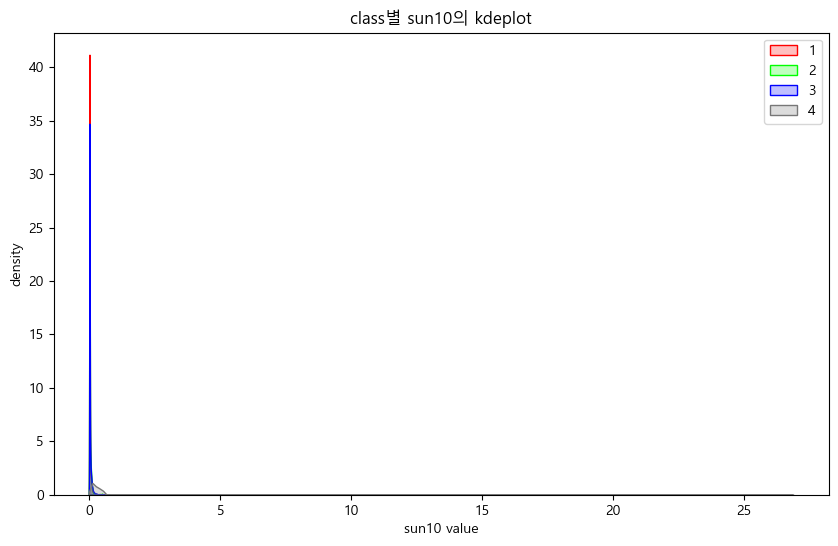

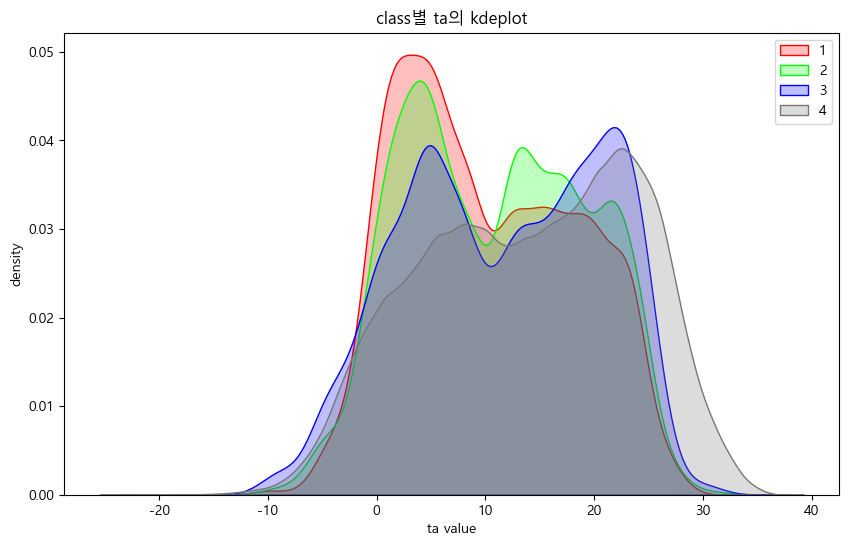

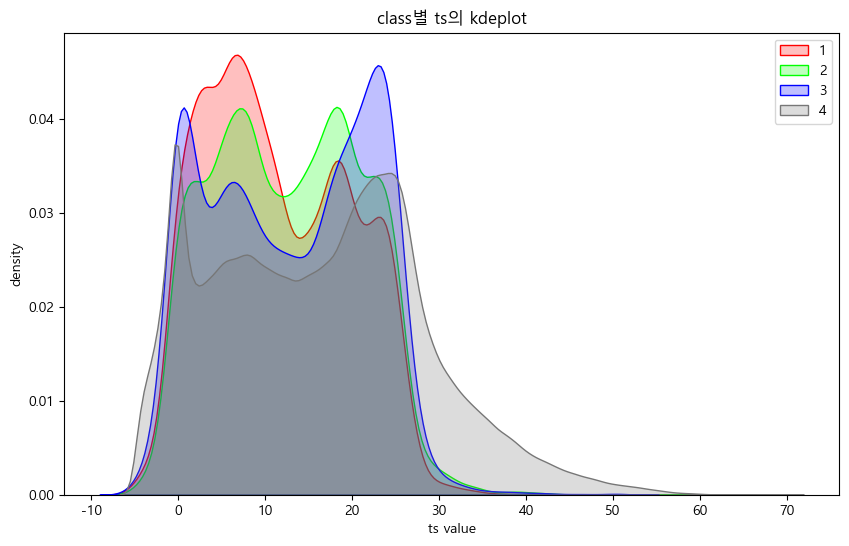

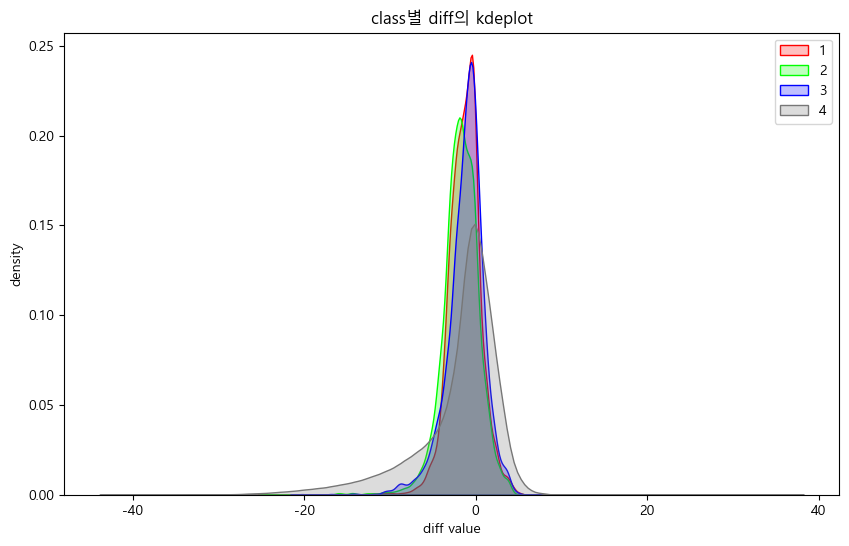

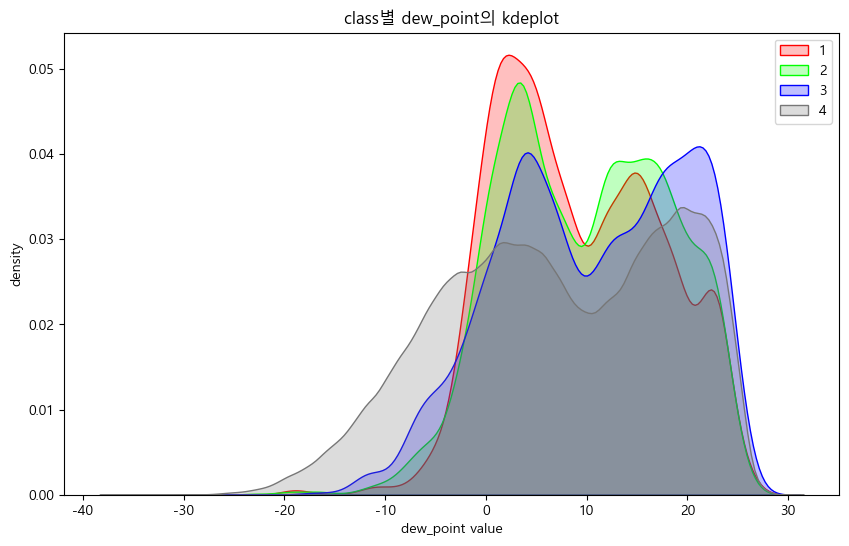

In [226]:
kde_factor_class(data_eda.drop(['stn_id', 're', 'dew_reached'], axis = 1))

#### 요소값들과 가시거리값의 관계

<Axes: >

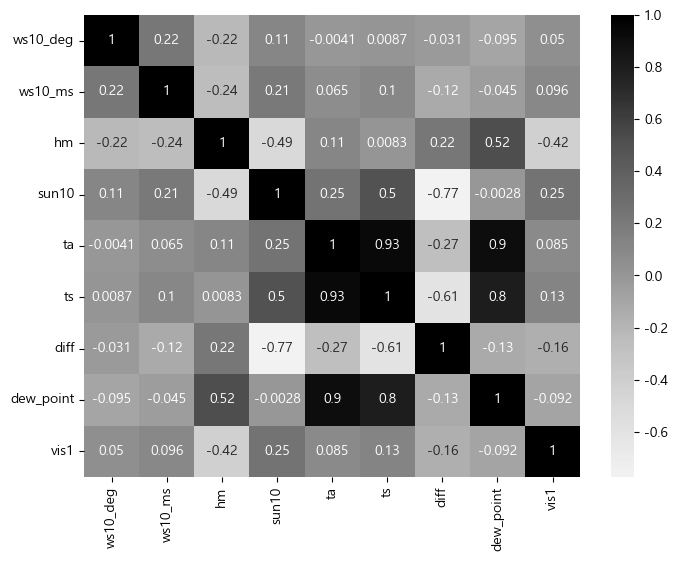

In [227]:
vis_adjusted_data = data_eda_con[data_eda_con.vis1 < 20000]

vis_corr = vis_adjusted_data.corr()
plt.figure(figsize = (8, 6))
sns.heatmap(vis_corr, annot = True, cmap = 'Greys', center = 0)

In [228]:
def line_factor_vis(dataset, y_column = 'vis1'):

    about_columns = dataset.columns[0:-2]

    for column in about_columns:
        plt.figure(figsize = (10, 6))
        sns.regplot(x = column, y = y_column, 
                    data=dataset, 
                    scatter_kws={'s': 50}, 
                    color = '#777777',
                    line_kws={'color': 'red'})
        plt.title(column + "과 가시거리값의 관계")
        plt.xlabel(column + " value")
        plt.ylabel('가시거리')
        plt.show();

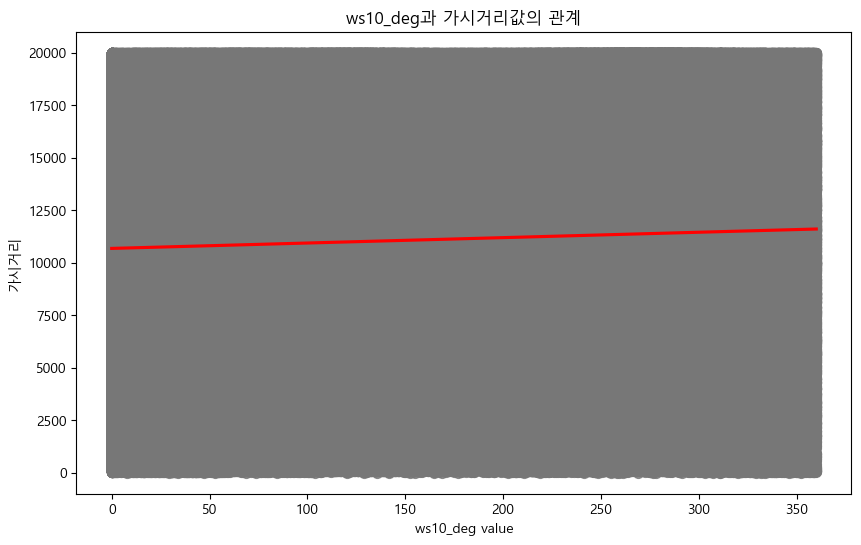

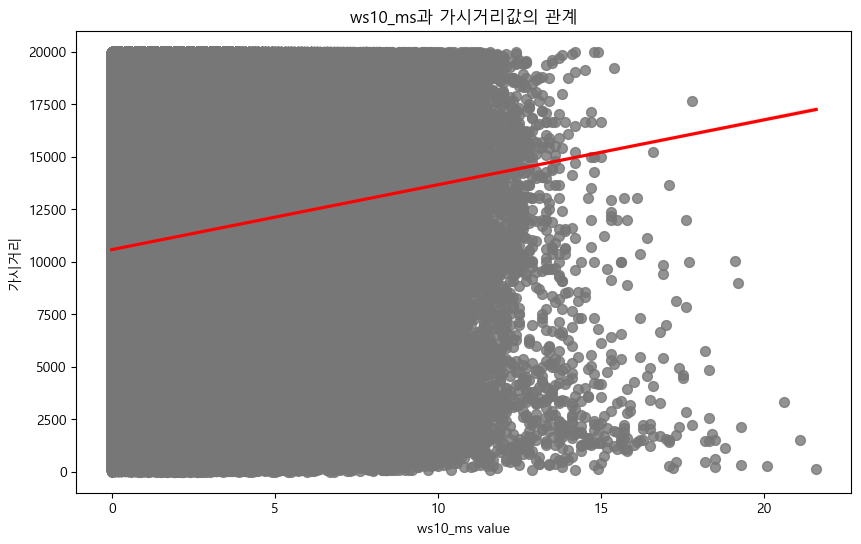

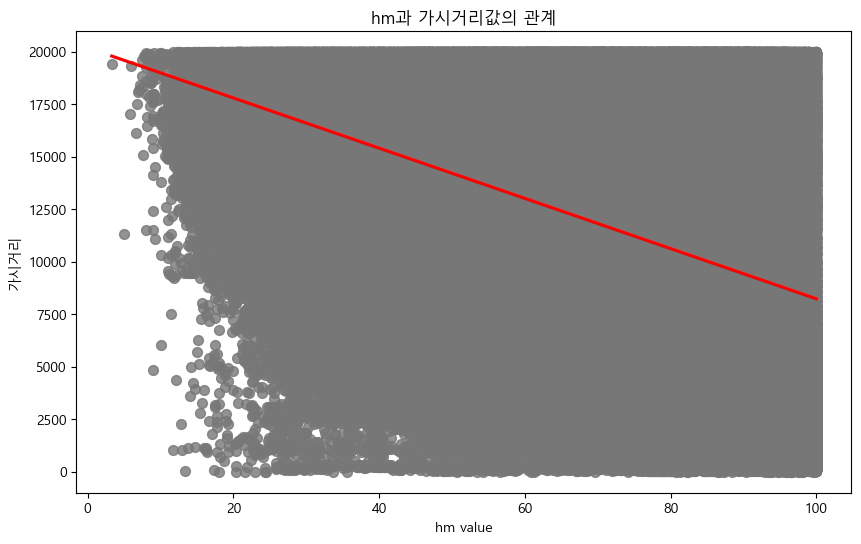

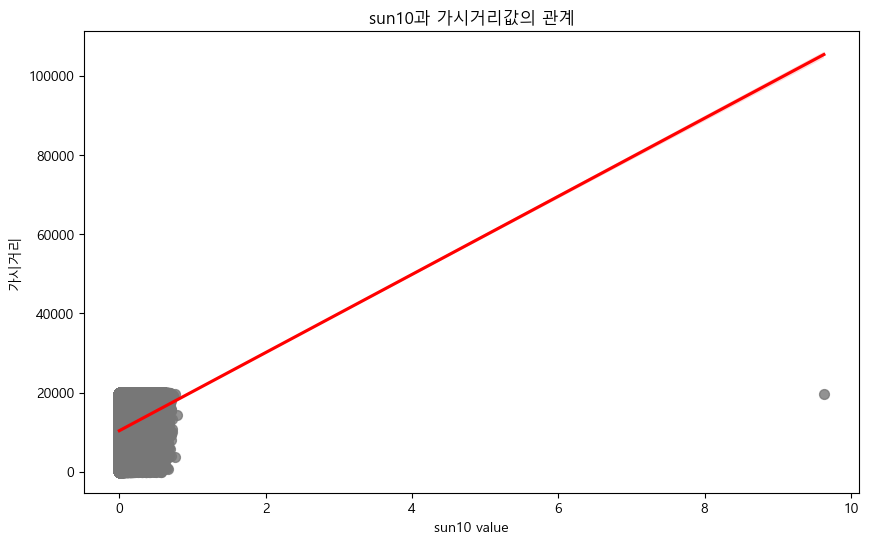

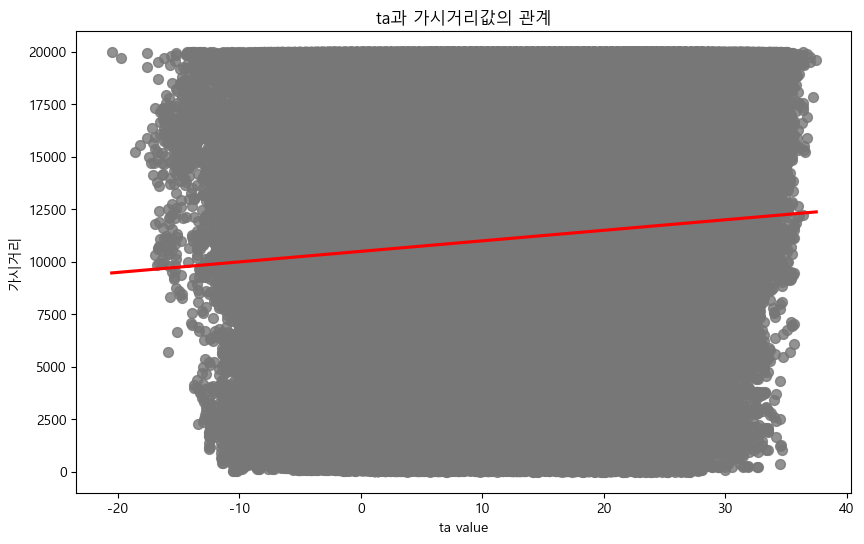

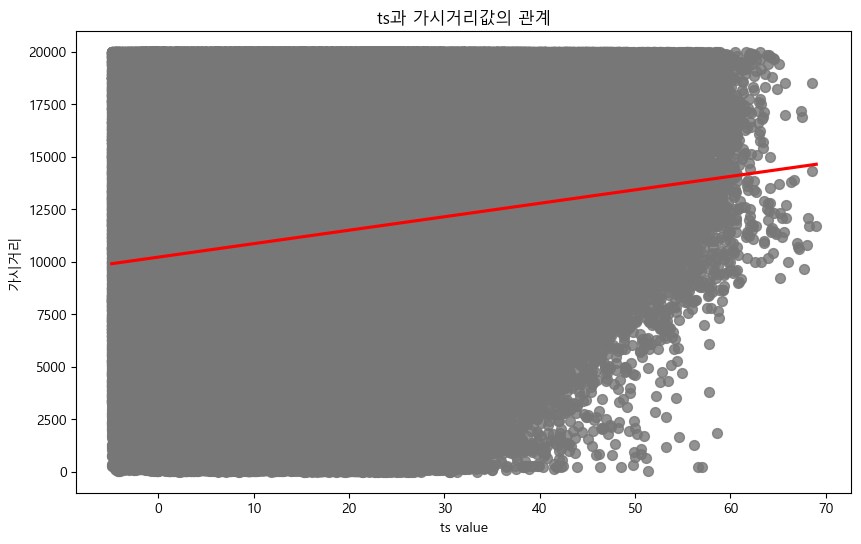

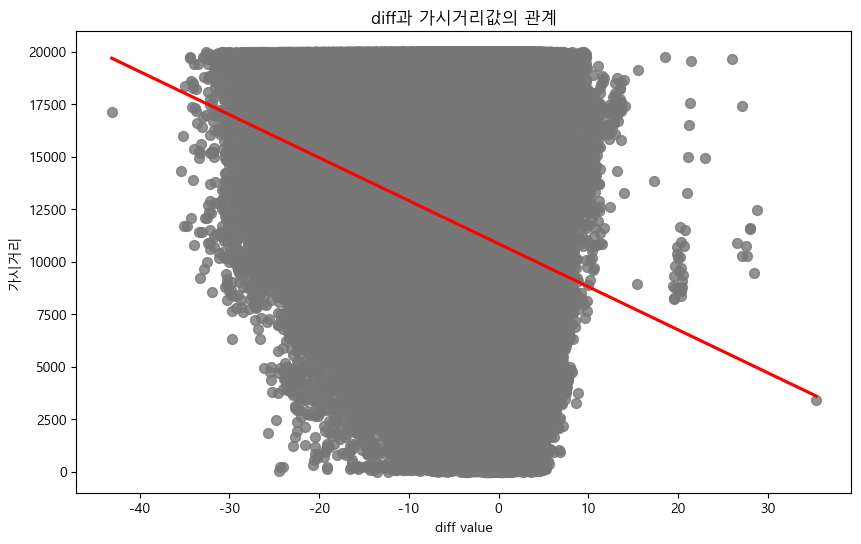

In [229]:
line_factor_vis(vis_adjusted_data)

### 범주형 변수

#### Cramer's V 상관관계

In [230]:
def cramer_V_on_class(dataset, y):

    cramer_df = pd.DataFrame(columns = ["column", "cramer V", "Degrees of Freedom"])
    
    for column in dataset.columns:
    
        cross_temp = np.array(pd.crosstab(y, dataset[column]))
        stat = chi2_contingency(cross_temp)[0]
        obs_n = np.sum(cross_temp)
        phi = stat / obs_n
        r, k = cross_temp.shape
        df = min(r-1, k-1)
        cramer_V = np.sqrt(phi / min(r-1, k-1))
        
        temp_row = pd.DataFrame({"column" : [column], "cramer V" : [cramer_V], "Degrees of Freedom" : [df]})
        cramer_df = pd.concat([cramer_df, temp_row], ignore_index = True)

    return cramer_df

- 자유도별 상관관계 해석

![image.png](attachment:bb84b484-ad81-4323-9c4e-e4f60f05e48d.png)

- https://www.statology.org/interpret-cramers-v/

In [231]:
cramer_on_class = cramer_V_on_class(data_eda[['stn_id', 're', 'dew_reached']], data_eda['class'])
cramer_on_class

,column,cramer V,Degrees of Freedom
0,stn_id,0.044101,3
1,re,0.091418,1
2,dew_reached,0.050169,1


#### 요소별 가시거리 평균

In [238]:
def avg_factor_vis(dataset, y_column = 'vis1'):

    about_columns = dataset.columns[0:-1]

    for column in about_columns:
        print("[ " + column + "별 가시거리 평균 / 표준표차 ]")
        print("-" * 40)

        for value in dataset[column].unique():
            temp_df = dataset[dataset[column] == value]
            print(column + "이 " + str(value) + "일 때의 가시거리 평균" + str(round(temp_df[y_column].mean(), 3)) + " / 표준편차 " + str(round(temp_df[y_column].std(), 3)))
            
        print("-" * 40)

- 전체 데이터셋

In [239]:
avg_factor_vis(data_eda[['stn_id', 're', 'dew_reached', 'vis1']])

[ stn_id별 가시거리 평균 / 표준표차 ]
----------------------------------------
stn_id이 1일 때의 가시거리 평균18176.541 / 표준편차 10196.853
stn_id이 2일 때의 가시거리 평균20025.563 / 표준편차 13436.894
stn_id이 3일 때의 가시거리 평균22283.283 / 표준편차 12958.136
stn_id이 4일 때의 가시거리 평균18494.383 / 표준편차 10841.076
stn_id이 5일 때의 가시거리 평균22394.867 / 표준편차 13466.405
----------------------------------------
[ re별 가시거리 평균 / 표준표차 ]
----------------------------------------
re이 0.0일 때의 가시거리 평균20193.185 / 표준편차 11797.89
re이 1.0일 때의 가시거리 평균9612.562 / 표준편차 9186.204
----------------------------------------
[ dew_reached별 가시거리 평균 / 표준표차 ]
----------------------------------------
dew_reached이 0일 때의 가시거리 평균19922.718 / 표준편차 11873.948
dew_reached이 1일 때의 가시거리 평균10305.98 / 표준편차 9035.652
----------------------------------------


- 가시거리가 20,000미만인 데이터셋

In [240]:
avg_eda_temp = data_eda[['stn_id', 're', 'dew_reached', 'vis1']]
vis_adjusted_temp = avg_eda_temp[avg_eda_temp['vis1'] < 20000]

In [241]:
avg_factor_vis(vis_adjusted_temp)

[ stn_id별 가시거리 평균 / 표준표차 ]
----------------------------------------
stn_id이 1일 때의 가시거리 평균10930.355 / 표준편차 5274.52
stn_id이 2일 때의 가시거리 평균11114.928 / 표준편차 5726.533
stn_id이 3일 때의 가시거리 평균11869.14 / 표준편차 5310.214
stn_id이 4일 때의 가시거리 평균10933.192 / 표준편차 5543.238
stn_id이 5일 때의 가시거리 평균11779.778 / 표준편차 5522.544
----------------------------------------
[ re별 가시거리 평균 / 표준표차 ]
----------------------------------------
re이 0.0일 때의 가시거리 평균11642.465 / 표준편차 5316.769
re이 1.0일 때의 가시거리 평균6765.432 / 표준편차 4819.876
----------------------------------------
[ dew_reached별 가시거리 평균 / 표준표차 ]
----------------------------------------
dew_reached이 0일 때의 가시거리 평균11373.648 / 표준편차 5416.09
dew_reached이 1일 때의 가시거리 평균7415.789 / 표준편차 4990.918
----------------------------------------
